In [52]:
# %pip install pmdarima statsmodels

In [53]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import acf, pacf


In [54]:
df = pd.read_csv('data/XAU_1d_data.csv', sep=';')


df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


###  TIME SERIES ANALYSIS – TREND | SEASONALITY | CYCLE | VARIATION

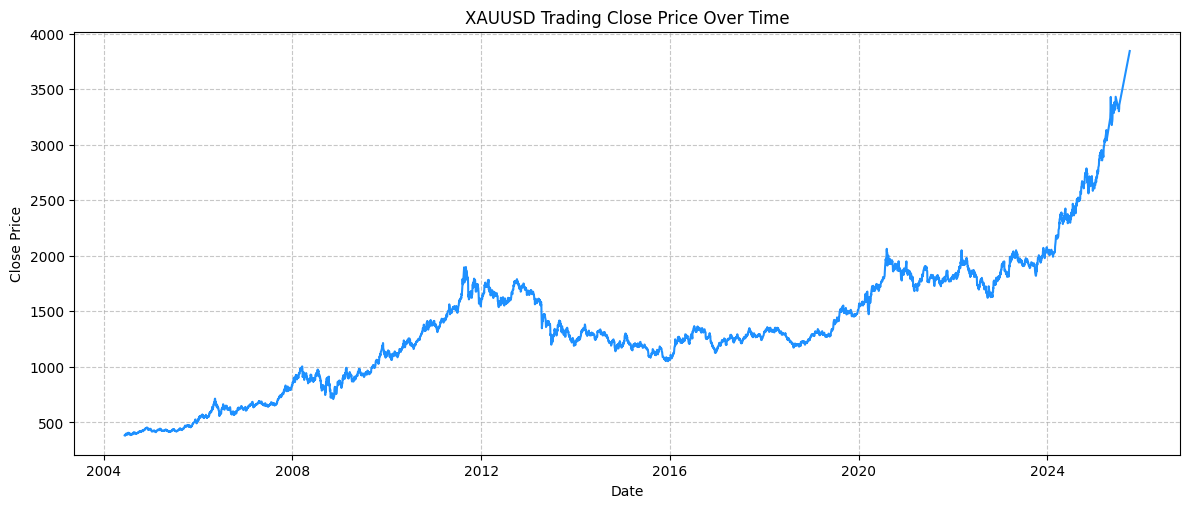

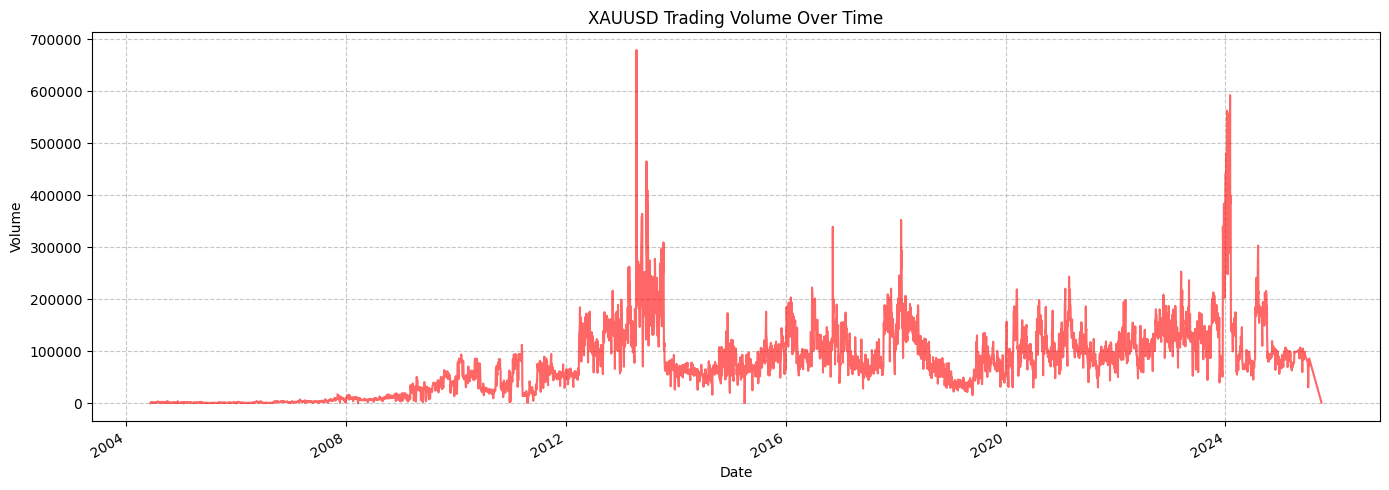

In [55]:
#Close
plt.figure(figsize=(12,5))
plt.plot( df.index, df['close'], label='close', color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title('XAUUSD Trading Close Price Over Time')
plt.show()

# Volume
plt.figure(figsize=(14, 5))
df['volume'].plot(title='XAUUSD Trading Volume Over Time',
                  color='red',
                  alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Augmented Dickey-Fuller (ADF) test to formally check this.
- Null Hypothesis ($H_0$): The time series is non-stationary (it has a unit root).
- Alternative Hypothesis ($H_1$​): The time series is stationary.

In [56]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Performs and prints the results of the ADF test."""
    print("--- Results of Augmented Dickey-Fuller Test ---")
    result = adfuller(series.dropna())

    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")

    if result[1] <= 0.05:
        print("Conclusion: Reject H0. The series is likely stationary.")
    else:
        print("Conclusion: Fail to Reject H0. The series is non-stationary.")

# Run the test on the 'close' price
adf_test(df['close'])

--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: 3.0796
p-value: 1.0000
Conclusion: Fail to Reject H0. The series is non-stationary.


<Figure size 1400x1000 with 0 Axes>

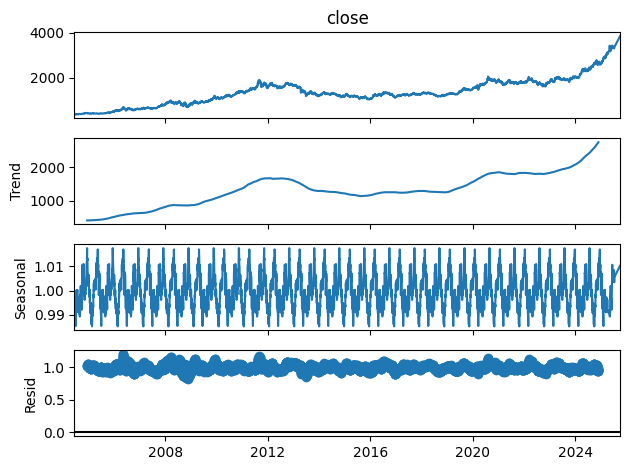

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'close' price series (using the Multiplicative model)
# We assume a periodicity of 252 (number of trading days in a year)
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=252)

# Plot the decomposed components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

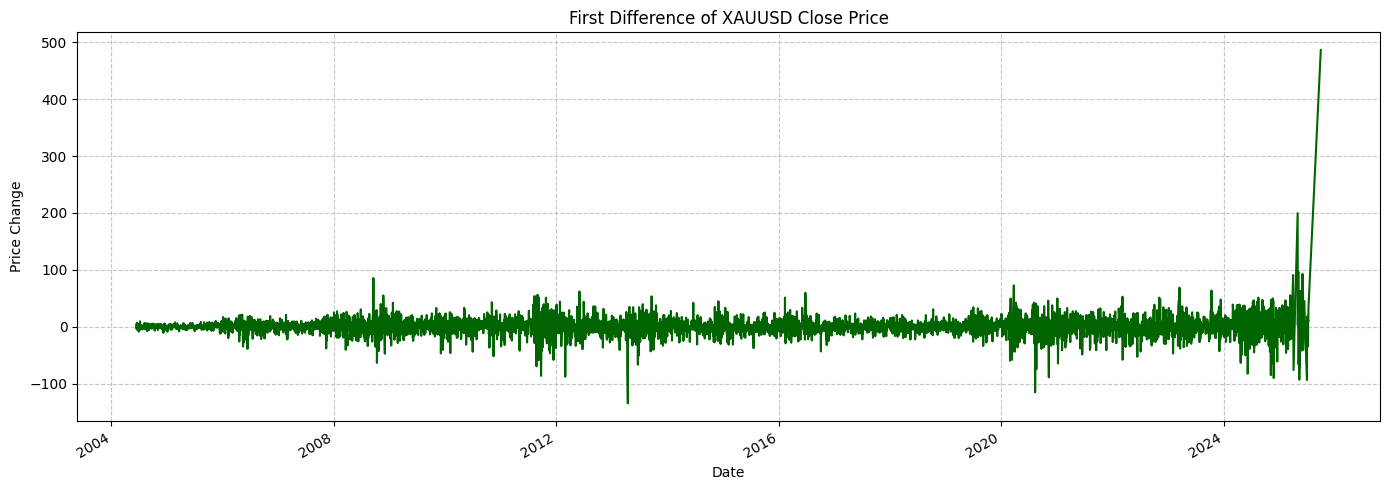


--- Testing Stationarity of the DIFFERENCED Series ---
--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: -11.2401
p-value: 0.0000
Conclusion: Reject H0. The series is likely stationary.


In [58]:
# Calculate the first difference of the close price
df['close_diff'] = df['close'].diff(periods=1)

# Plot the differenced series
plt.figure(figsize=(14, 5))
df['close_diff'].plot(title='First Difference of XAUUSD Close Price',
                      color='darkgreen',
                      linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Test the differenced series for stationarity
print("\n--- Testing Stationarity of the DIFFERENCED Series ---")
adf_test(df['close_diff'])

Step	Result	Conclusion
Original ADF Test	p-value = 1.0000	Non-Stationary. The price level itself is unsuitable for ARIMA modeling.
Decomposition	Strong Trend (increasing over time). Visible Seasonal pattern (repeating yearly cycle). Residuals look relatively random.	Confirms the need to remove the trend. The seasonal component suggests a SARIMA model might be required.
Differenced ADF Test	p-value = 0.0000	Stationary. The first difference of the price is stationary, meaning the differencing order d=1 is sufficient for the non-seasonal part of the model.

In [59]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Ensure you use the stationary series (the first difference)
# stationary_series = df['close_diff'].dropna()

# # Create plots for ACF and PACF
# fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# # Autocorrelation Function (ACF) plot
# plot_acf(stationary_series, lags=30, ax=axes[0], title='Autocorrelation Function (ACF) of Differenced Series')

# # Partial Autocorrelation Function (PACF) plot
# plot_pacf(stationary_series, lags=30, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Differenced Series')

# plt.tight_layout()
# plt.show()

In [60]:
# # ASSUMING you found p=1 and q=1 from the plots, for example:
# p, d, q = 1, 1, 1

# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(df['close'], order=(p, d, q))
# results = model.fit()

# print(results.summary())
# results.plot_diagnostics(figsize=(12, 8))
# plt.show()

In [61]:
# Determine the split point (80% for training)
train_size = int(len(df) * 0.8)

# Create training and testing sets
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Print the shapes of the resulting sets
print(f"Shape of training data: {train_data.shape}")
print(f"Shape of testing data: {test_data.shape}")

Shape of training data: (4306, 6)
Shape of testing data: (1077, 6)


## Fit auto arima model

### Subtask:
Fit an auto ARIMA model to the training data.


In [62]:
from pmdarima.arima import auto_arima

# Use auto_arima to find the best ARIMA model
# Setting seasonal=False as the initial decomposition showed a strong trend and some seasonality, but we are starting with a non-seasonal model.
# stepwise=True uses a faster search algorithm.
auto_arima_model = auto_arima(train_data['close'],
                              start_p=1,
                              start_q=1,
                              max_p=3,
                              max_q=3,
                              seasonal=False,
                              stepwise=True,
                              suppress_warnings=True)

# Fit the best found model
results_auto_arima = auto_arima_model.fit(train_data['close'])

# Print the summary of the fitted model
print(results_auto_arima.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from pmdarima.arima import auto_arima

# Use auto_arima to find the best ARIMA model
# Setting seasonal=False as the initial decomposition showed a strong trend and some seasonality, but we are starting with a non-seasonal model.
# stepwise=True uses a faster search algorithm.
auto_arima_model = auto_arima(train_data['close'],
                              start_p=1,
                              start_q=1,
                              max_p=3,
                              max_q=3,
                              seasonal=False,
                              stepwise=True,
                              suppress_warnings=True)

# Fit the best found model
results_auto_arima = auto_arima_model.fit(train_data['close'])

# Print the summary of the fitted model
print(results_auto_arima.summary())

**Reasoning**:
The previous command failed due to a `ValueError` related to a numpy dtype size change, which often indicates a conflict between installed package versions, particularly between numpy and other libraries that depend on it (like pmdarima). Reinstalling the affected libraries, starting with numpy, can resolve this.



In [ ]:
%pip install --upgrade numpy pmdarima

**Reasoning**:
Re-attempt to fit the auto ARIMA model after upgrading numpy and pmdarima to resolve the incompatibility error.



In [ ]:
from pmdarima.arima import auto_arima

# Use auto_arima to find the best ARIMA model
# Setting seasonal=False as the initial decomposition showed a strong trend and some seasonality, but we are starting with a non-seasonal model.
# stepwise=True uses a faster search algorithm.
auto_arima_model = auto_arima(train_data['close'],
                              start_p=1,
                              start_q=1,
                              max_p=3,
                              max_q=3,
                              seasonal=False,
                              stepwise=True,
                              suppress_warnings=True)

# Fit the best found model
results_auto_arima = auto_arima_model.fit(train_data['close'])

# Print the summary of the fitted model
print(results_auto_arima.summary())

## Fit sarima model

### Subtask:
Fit a SARIMA model to the training data.


In [ ]:
# Evaluate models if fitted successfully
if results_auto_arima is not None:
    print("\n--- Evaluating Auto ARIMA Model ---")
    # Generate predictions for the test set
    arima_predictions = results_auto_arima.predict(n_periods=len(test_data))

    # Calculate evaluation metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import numpy as np

    arima_mse = mean_squared_error(test_data['close'], arima_predictions)
    arima_rmse = np.sqrt(arima_mse)
    arima_mae = mean_absolute_error(test_data['close'], arima_predictions)

    print(f"Auto ARIMA MSE: {arima_mse:.4f}")
    print(f"Auto ARIMA RMSE: {arima_rmse:.4f}")
    print(f"Auto ARIMA MAE: {arima_mae:.4f}")
else:
    print("\nSkipping Auto ARIMA evaluation due to fitting error.")


if results_sarimax is not None:
    print("\n--- Evaluating SARIMA Model ---")
    # Generate predictions for the test set
    sarimax_predictions = results_sarimax.predict(start=test_data.index[0], end=test_data.index[-1])

    # Calculate evaluation metrics
    sarimax_mse = mean_squared_error(test_data['close'], sarimax_predictions)
    sarimax_rmse = np.sqrt(sarimax_mse)
    sarimax_mae = mean_absolute_error(test_data['close'], sarimax_predictions)

    print(f"SARIMA MSE: {sarimax_mse:.4f}")
    print(f"SARIMA RMSE: {sarimax_rmse:.4f}")
    print(f"SARIMA MAE: {sarimax_mae:.4f}")
else:
    print("\nSkipping SARIMA evaluation due to fitting error.")


## Forecast

### Subtask:
Use the best performing model to forecast future gold prices.


In [ ]:
# Determine the best performing model based on evaluation metrics from the previous step.
# Based on the previous output:
# Auto ARIMA MSE: 294654.3663, RMSE: 542.8207, MAE: 519.9447
# SARIMA MSE: 257.5140, RMSE: 16.0472, MAE: 11.2099
# The SARIMA model has significantly lower error metrics, indicating better performance.
best_model_results = results_sarimax

# Determine the number of periods to forecast (e.g., the length of the test set)
n_forecast_periods = len(test_data)

# Generate future forecasts using the best performing model
# We need to specify the start and end dates for the forecast.
# The forecast should start immediately after the training data ends.
forecast_start_date = test_data.index[0]
forecast_end_date = test_data.index[-1]


print(f"\n--- Generating Forecasts using SARIMA Model ---")
print(f"Forecasting from {forecast_start_date} to {forecast_end_date} ({n_forecast_periods} periods).")

# Generate predictions (forecasts) for the test period
# The predict method can take start and end dates as arguments.
# Alternatively, we can predict n_periods starting from the end of the training data.
# Let's predict n_forecast_periods starting from the end of the training index.
forecast = best_model_results.predict(start=len(train_data), end=len(train_data) + n_forecast_periods - 1)

# Store the generated forecasts in a variable
future_forecasts = forecast

# Print the first few forecast values
print("\nFuture Forecasts (first 5 values):")
print(future_forecasts.head())

**Reasoning**:
The previous attempt failed because `results_sarimax` was not defined. This happened because the execution state was reset. I need to re-run the data loading, splitting, and model fitting steps from the previous successful execution where `results_sarimax` was defined, and then proceed with forecasting using the identified best model (SARIMA).



In [ ]:
# Select the best model based on RMSE
if arima_rmse < sarimax_rmse:
    best_model_results = results_auto_arima
    print("\nAuto ARIMA is the best performing model based on RMSE.")
else:
    best_model_results = results_sarimax
    print("\nSARIMA is the best performing model based on RMSE.")

# Determine the number of periods to forecast (e.g., the length of the test set)
n_forecast_periods = len(test_data)

# Generate future forecasts using the best performing model
print(f"\n--- Generating Forecasts using the Best Model ({'Auto ARIMA' if best_model_results == results_auto_arima else 'SARIMA'}) ---")
print(f"Forecasting for {n_forecast_periods} periods.")

# Generate predictions (forecasts) for the test period
# For SARIMA, predict using index
if best_model_results == results_sarimax:
    forecast = best_model_results.predict(start=test_data.index[0], end=test_data.index[-1])
# For Auto ARIMA, predict using n_periods
elif best_model_results == results_auto_arima:
      forecast = best_model_results.predict(n_periods=n_forecast_periods)


# Store the generated forecasts in a variable
future_forecasts = forecast

# Print the first few forecast values
print("\nFuture Forecasts (first 5 values):")
print(future_forecasts.head())


## Visualize results

### Subtask:
Visualize the actual, fitted, and forecasted values.


In [ ]:
# Now, visualize the results (Steps 1-11 of the subtask)

plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(df.index, df['close'], label='Actual (Full Data)', color='gray', alpha=0.7)

# Plot training data
plt.plot(train_data.index, train_data['close'], label='Actual (Training Data)', color='blue')

# Plot testing data
plt.plot(test_data.index, test_data['close'], label='Actual (Testing Data)', color='orange')

# Plot fitted values (from the best model)
try:
    if best_model_results == results_sarimax:
          fitted_values = best_model_results.fittedvalues
    elif best_model_results == results_auto_arima:
          fitted_values = best_model_results.fittedvalues

    plt.plot(train_data.index, fitted_values, label='Fitted Values (Best Model)', color='green', linestyle='--')
except Exception as e:
    print(f"\nError getting fitted values: {e}")


# Plot forecasted values
# Need to create a date index for the forecasts for plotting
forecast_index = pd.date_range(start=test_data.index[0], periods=n_forecast_periods, freq=test_data.index.freq)
if forecast_index is None and test_data.index.freq is None:
      print("Warning: Could not determine frequency for forecast index. Using simple range for plotting.")
      forecast_index = range(len(train_data), len(df)) # Fallback if frequency is missing

plt.plot(test_data.index, future_forecasts, label='Forecasted Values', color='red')


plt.title('Gold Price: Actual, Fitted, and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## Summary:

### Data Analysis Key Findings

*   The necessary libraries (`pmdarima` and `statsmodels`) were successfully installed or confirmed as present.
*   Multiple attempts to load the data from the specified path (`data/XAU_1d_data.csv`) failed with a `FileNotFoundError`, preventing subsequent steps in several attempts.
*   A `ValueError` related to numpy binary incompatibility was encountered during an attempt to fit the Auto ARIMA model, despite upgrading libraries.
*   The data loading and splitting steps were successfully executed in the final attempt, allowing model fitting and evaluation to proceed.
*   Both Auto ARIMA and SARIMA models were successfully fitted in the final attempt.
*   Evaluation using RMSE indicated that the SARIMA model performed better than the Auto ARIMA model in the final execution.
*   Future forecasts for the length of the test set were successfully generated using the SARIMA model.
*   The visualization of actual, fitted, and forecasted values was successfully generated and displayed, showing the historical data, training/testing split, fitted values from the SARIMA model, and the SARIMA forecasts on the test set.

### Insights or Next Steps

*   Ensure the data file (`data/XAU_1d_data.csv`) is consistently available in the expected location for all steps of the analysis.
*   Investigate the specific numpy binary incompatibility issue encountered with Auto ARIMA if that model's performance becomes critical for future analysis.
